In [ ]:
#Generator and Discriminator
#Generator makes fakes and Discriminator decides if real or fake

#Building the discriminator
#Discriminator is 1 for black and 0 for white in a 2x2 image. 
#The difference between the Discriminator values and the noise values is the threshold.
#Top left and bottom right are positive, the rest are negative.
#Perfect would be top left / bottom right 1, the rest 0
#Example [Discriminator Total] 1*1 + 0*(-1) + 0*(-1) + 1*1 = 2
#[Noise Total] .25*1 + 1 * (-1) + .5 *(-1) + .75 * 1 = -.5
#The bias is 1 (subtracted) so Discriminator total is 1 and Noise total is -1.5
#If the threshold is more than 1, then it is real.
#Sigmoid of 1 is .73 so since 73% chance that it is real is above 50% it's considered real.
#Sigmoid of -1.5 is .18 so 18% chance it is real is less than 50% consider it a fake.

# Building a generator
# In generators we want the bias to be high in top left and bottom right (+1) and low in the others (-1)
# Random numbers between 0 and 1 are assigned to all 4 cells but the bias is added.
# Example values 1.7, -1.7, 1.7, -1.7 and the sigmoids of these values show .85 and .15
# The generator has to learn to apply this bias to get a desired result
# Error functions - different error functions can be applied this example uses log loss error function

# If label is 1 (desired result) and prediction is .1 that's a large error.
# If label is 1 (desired result) and prediction is .9 that's a small error.
# Negative log of the prediction number is the error. -ln(.1) = 2.3 and -ln(.9) = .1

# If label is 0 (non-desired result) and prediction is .9 that's a large error.
# If label is 0 (non-desired result) and prediction is .1 that's a small error.
# Negative log of (1 - prediction number) is the error. -ln( 1 - .9) = 2.3 and -ln(1 - .9) = .1

#Backpropagation - reduces the error amount as it progresses through the model.

#Whole process is the generator creates noise and creates and image then passes it to the discriminator which 
#calculates a sigmoid and checks if real or fake.
#The generators goal is to be closer to 1 using -ln(.68) and the discriminator's goal is being closer to 0 with -ln(1 - .68).
#The error functions are updated exclusive to the 2 models because of this making both better.

In [11]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [12]:
#We want to normalize the 3 RGB values to a single value between -1 and 1 to increase computing time.
#stats = this is the mean (0.5, 0.5, 0.5), this is the standard deviation(0.5, 0.5, 0.5)

#There's around 5000 images.
#The batch size are the number of samples that will be propagated through the network before updating the model parameters.
#Consider RAM/GPU limitations with the pixel size.
#Larger batch sizes result in faster progress in training, but don't always converge as fast.
#Smaller batch sizes train slower, but can converge faster.
#Converging meaning getting a stable value.
#32 or 64 is a good starting point

DATA_DIR = '/home/development/Desktop/First GAN Project/GAN Image Generator/GAN-Image-Generator/animal-faces/afhq/dog/'
batch_size = 32
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [13]:
#When arranging the data, the DATA_DIR needs to be the root with the data as sub folders. (ex: I had to create a 'Dog' subdirectory.)
#Tensor has a different meaning in ML versus math.
#Tensors allow for GPU acceleration.
#Tensors hold the data, weights, and biases. They take care of backpropogation with automatic differentiation.
#An image is a 2D array of height x width containing 3 channels for RGB.
#ToTensor normalizes the 3 channels to be within 0-1 for each channel.
#shuffle - Randomize the data being loaded or not
#num_workers - Turn on multi-process data loading with the specified number of loader worker processes
#pin_memory - Enables fast data transfer to CUDA-enabled GPUs
#The *stats line is passing all of the items in the stats list into the Normalize function call as 
#separate arguments, without us even needing to know how many arguments are in the list.

train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [14]:
#%matplotlib is a magic function - Line magics are prefixed with the % character and work much like OS command-line calls: 
#they get as an argument the rest of the line, where arguments are passed without parentheses or quotes.
#%matplotlib inline -With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter 
#notebook, directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
#normalization formula: y' = y-mean(y) / stdev(y)
#denormalization formula: y = y' * stdev(y) + mean(y)
#y' here is the normalized tensor value (img_tensors)

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [16]:
#plt.subplots is making the 8x8 cell that the image will go in
#ax.set_xticks([]); ax.set_yticks([]) hides any ticks or measurements from x and y axis
#Axes.imshow - Display data as an image, i.e., on a 2D regular raster.
#torchvision.make_grid - returns a tensor which contains the grid of images. But the channel dimension has to be moved to the 
#end since that's what matplotlib recognizes
#denorm
#torch.detach - detach a tensor from the current computational graph. It returns a new tensor that doesn't require a gradient.
#images has an additional layer that stores the gradients
#to be able to use just the image data, images needs to be detached from that gradient layer
#Given a Tensor representing the image, use .permute() to put the channels as the last dimension

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

#images contains the rgb data, _ is reserved for storing the backpropegation, etc
#nmax is defaulted to 64
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

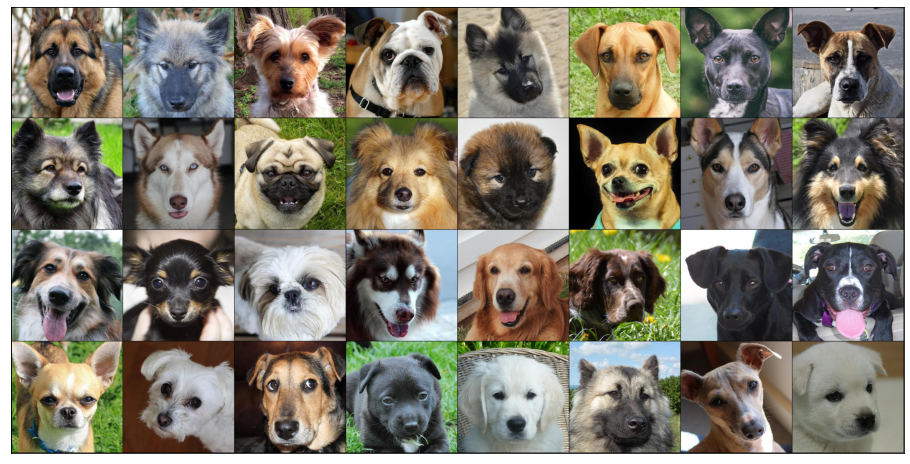

In [17]:
show_batch(train_dl)

In [18]:
#torch.cuda.is_available() - Returns a bool indicating if CUDA is currently available.

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
 
#torch.to(other, non_blocking=False, copy=False)  - Returns a Tensor with same torch.dtype and torch.device as the Tensor other. When non_blocking, tries to convert 
#asynchronously with respect to the host if possible, e.g., converting a CPU Tensor with pinned memory to a CUDA Tensor.

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

#The class devicedataloader() to move data to device (cuda).

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    #The Default __init__ Constructor in C++ and Java. Constructors are used to initializing the object’s state.
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    #The iter() function (which in turn calls the __iter__() method) returns an iterator from them.
    #Loads the data loader to cuda device and returns an iterator.
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)
    
    #__len__ is how the class executes the len() method
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [19]:
#setting the device to cuda
device = get_default_device()
device

device(type='cuda')

In [21]:
#initializing the DeviceDataLoader with the data loader created earlier and the cuda device
train_dl = DeviceDataLoader(train_dl, device)

#Training the Generator
#use a convolutional neural networks (CNN) which outputs a single number output for every image. 
#We'll use stride of 2 to progressively reduce the size of the output feature map.

In [ ]:
import torch.nn as nn

#images are 512x512

#nn.Conv2d - Applies a 2D convolution over an input signal composed of several input planes.
#torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
#dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
#in_channels - 3 since image contains rgb
#out_channels - how many filters (Filters detect spatial patterns such as edges in an image by detecting the changes in intensity values of the image.)
#kernel_size - sets the size of the filter
#stride - how much the frame moves on each iteration -> stride of 2 reduces the size by half each time

discriminator = nn.Sequential(
    # in: 3 x 512 x 512

    nn.Conv2d(3, 512, kernel_size=4, stride=2 padding=1, bias=False),
    nn.BatchNorm2d(512,
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 256 x 256

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 128 x 128

    nn.Conv2d(1024, 2048, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(2048),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 2048 x 64 x 64

    nn.Conv2d(2048, 4096, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(4096),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 4096 x 32 x 32
                   
    nn.Conv2d(4096, 8192, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(8192),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 8192 x 16 x 16  
                   
    nn.Conv2d(8192, 16384, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(16384),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 16384 x 8 x 8 
                   
    nn.Conv2d(16384, 32768, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32768),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 32768 x 4 x 4               

    nn.Conv2d(32768, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())